This notebook helps test a local or pip installed copy of llmsherpa with the ingestor core code

In [1]:
!pip install llmsherpa

You should consider upgrading via the 'C:\Users\fabia\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


## Add llmsherpa
###  This is used to parse PDFs and allows for smart chunking based on the documents structure (chapters, sections, tables, paragraphs).

In [1]:
import os, sys
%load_ext autoreload
from llmsherpa.readers import LayoutPDFReader
from IPython.core.display import display, HTML
%autoreload 2

C:\Users\fabia\AppData\Local\Temp\ipykernel_22584\1052947477.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
directory_path = "/Users/fabia/Desktop/testapi"
sys.path.insert(0, directory_path)


llmsherpa_api_url = "http://localhost:5001/api/parseDocument?renderFormat=all&useNewIndentParser=true"
pdf_file = "et200sp_system_manual_en-US_en-US_stripped.pdf"
pdf_url = "data/" + pdf_file
# pdf_url = "data/Lebenslauf_Fabian_Seiler.pdf"
# pdf_url = "data/test_manual_new.pdf"


do_ocr = True
if do_ocr:
    llmsherpa_api_url = llmsherpa_api_url + "&applyOcr=yes"
pdf_reader = LayoutPDFReader(llmsherpa_api_url)
doc = pdf_reader.read_pdf(pdf_url)

## Complete parsed document:

In [36]:
# HTML(doc.sections()[0].to_html(include_children=True, recurse=True))
# doc.sections()[1].block_json
# doc.sections()[0].to_text()
# doc.sections()[1].bbox
# llmsherpa.readers.Layout
HTML(doc.to_html())

①,BusAdapter
②,Mounting rail
③,Reference identification label
④,CPU/interface module
⑤,Light-colored BaseUnit BUD with infeed of supply voltage
⑥,Dark-colored BaseUnits BUB for conducting the potential group further
⑦,BaseUnit for motor starters
⑧,Potential distributor module
⑨,Ex BaseUnit for Ex power module
⑩,Ex BaseUnit for Ex I/O module
⑪,Server module (included in the scope of supply of the CPU/interface module)


## Parsed Chunks

In [4]:
for chunk in doc.chunks():
    print(chunk.to_context_text())
    print("-"*80)

SYSTEM MANUAL
11/2023Edition
--------------------------------------------------------------------------------
SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP
SIMATIC ET 200SP is a scalable and highly flexible distributed I/O system for connecting process signals to a higher-level controller via a fieldbus.
--------------------------------------------------------------------------------
SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application
Thanks to its multifunctionality, the SIMATIC ET 200SP distributed I/O system is suitable for a wide range of applications.
Its scalable design allows you to tailor your configuration to local requirements.
Various CPUs/interface modules are available for connection to PROFINET IO, PROFIBUS DP, EtherNet/IP or Modbus TCP.
--------------------------------------------------------------------------------
SIM

In [5]:
for chunk in doc.chunks():
    if chunk.parent.title == "Mounting rules for reducing the thermal load":
        print(chunk.to_context_text())
        print()
        print("-"*80)


7.1 Basics > Mounting rules for reducing the thermal load
The following rules reduce the thermal load of the ET 200SP distributed I/O system in the control cabinet:
• Separate 2 modules with high power dissipation with a module of low power dissipation or by an empty space.
• Mix modules with higher power dissipation and modules with less power dissipation.
For example, modules with 16 outputs have a higher power dissipation than modules with 8 outputs.
• You should give preference to the horizontal mounting position.
• For vertical mounting position, plug modules with high power dissipation at the top, the interface module/CPU at the bottom.
7.2 Installation conditions for motor starters

--------------------------------------------------------------------------------
7.1 Basics > Mounting rules for reducing the thermal load
Mount an ET 200SP station with modules with high power dissipation in the lower area of the control cabinet.

----------------------------------------------------

### Post process the parsed chunks
As the parsed chunks can be to graniular we merge chunks that belong to the same (sub)section. We also merge the corresponding metadata like section, page_idx, parent, ...

In [3]:
def get_chunk_parent_titles(chunk):
    # Build a string that consists of recursively getting the chunk parent titles
    parent_titles = ""
    parent = chunk.parent
    while parent:
        try:
            parent_titles = parent.title + " > " + parent_titles
            parent = parent.parent
        except Exception as e:
            break
    # Remove the trailing " >"
    parent_titles = parent_titles.rstrip(" >")
    return parent_titles

In [4]:
# We want the full context_text without the section title. The section title is included in the metadata

def remove_first_line(text):
    lines = text.splitlines(True)[1:]  # splitlines(True) keeps the line breaks
    return ''.join(lines)

beforeString = doc.chunks()[3].to_context_text()
print("Before: ")
print(beforeString)
print()
print("After: ")
afterString = remove_first_line(beforeString)
print(afterString)

Before: 
SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application
SIMATIC ET 200SP with CPU allows intelligent pre-processing to relieve the higher-level controller.
The CPU can also be used as standalone device.

After: 
SIMATIC ET 200SP with CPU allows intelligent pre-processing to relieve the higher-level controller.
The CPU can also be used as standalone device.


### Parse new custom chunks
We merge chunks and parse their metadata into new custom chunks

In [5]:
# Dictionary to store merged content
merged_chunks = {}

# Iterate through each chunk and merge content
for chunk in doc.chunks():
    parent_section_hierarchy = get_chunk_parent_titles(chunk) # E.g. 'Installation > 7.3 Mounting the CPU/interface module > Dismantling the CPU/interface module'
    parent_section = chunk.parent.title # E.g. 'Dismantling the CPU/interface module'
    text = remove_first_line(chunk.to_context_text())
    page_idx = chunk.page_idx + 1 
    level = chunk.level

    if parent_section_hierarchy not in merged_chunks:
        merged_chunks[parent_section_hierarchy] = {
            "text": text,
            "start_page": page_idx,
            "end_page": page_idx,
            "parent_section": parent_section,
            "level": level
        }
    else:
        merged_chunks[parent_section_hierarchy]["text"] += "\n" + text
        merged_chunks[parent_section_hierarchy]["end_page"] = max(merged_chunks[parent_section_hierarchy]["end_page"], page_idx)

# Convert the merged dictionary back to list of chunks with updated page_nr
final_chunks = []
for parent_section_hierarchy, data in merged_chunks.items():
    start_page = data["start_page"]
    end_page = data["end_page"]
    if start_page == end_page:
        page_nr = str(start_page) # If there is only one page set that as the page number
    else:
        page_nr = f"{start_page}-{end_page}" # If there are multiple pages set the range as the page number
    
    final_chunks.append({
        "parent_section_hierarchy": parent_section_hierarchy,
        "text": data["text"],
        "page_nr": page_nr,
        "parent_section": data["parent_section"],
        "level": data["level"]
    })

# Output the final chunks
for chunk in final_chunks:
    print(f"Parent Section Hierarchy: {chunk['parent_section_hierarchy']}")
    print(f"Page Nr: {chunk['page_nr']}")
    print(f"Parent Section: {chunk['parent_section']}")
    print(f"Level: {chunk['level']}")
    print(f"Text: {chunk['text']}")
    print("="*80)


Parent Section Hierarchy: SYSTEM MANUAL
Page Nr: 1
Parent Section: SYSTEM MANUAL
Level: 1
Text: 11/2023Edition
Parent Section Hierarchy: SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP
Page Nr: 2
Parent Section: SIMATIC ET 200SP
Level: 5
Text: SIMATIC ET 200SP is a scalable and highly flexible distributed I/O system for connecting process signals to a higher-level controller via a fieldbus.
Parent Section Hierarchy: SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application
Page Nr: 4
Parent Section: Area of application
Level: 6
Text: Thanks to its multifunctionality, the SIMATIC ET 200SP distributed I/O system is suitable for a wide range of applications.
Its scalable design allows you to tailor your configuration to local requirements.
Various CPUs/interface modules are available for connection to PROFINET IO, PROFIBUS DP, EtherNet/IP or Mod

### Print chunk metadata

In [6]:
def print_chunk_metadata(chunk):
    # print("Full json: ", chunk.block_json)
    # print()
    print("Page Nr: ", chunk.page_idx + 1)
    print("Tag: ", chunk.tag)
    print("Parent Section: ", chunk.parent.title)
    print("Level in the hierarchy: ", chunk.level)
    print("Parent Section Hierarchy: ", get_chunk_parent_titles(chunk))
    # print("Text: ", chunk.to_text())
    print()
    print("Context Text: ", chunk.to_context_text())
    print()
    print("="*100)


chunk = doc.chunks()[26]
print_chunk_metadata(chunk)


Page Nr:  8
Tag:  table
Parent Section:  Example of a configuration with fail-safe I/O modules
Level in the hierarchy:  5
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.3 How are SIMATIC Safety F-systems structured with ET 200SP? > Example of a configuration with fail-safe I/O modules

Context Text:  SIMATIC > ET 200SP > System overview > 5.3 How are SIMATIC Safety F-systems structured with ET 200SP? > Example of a configuration with fail-safe I/O modules
 | ① | Interface module
 | ② | Light-colored BaseUnit BUD with infeed of supply voltage
 | ③ | Dark-colored BaseUnits BUB for conducting the potential group further
 | ④ | I/O module
 | ⑤ | Server module (ships with the interface module)
 | ⑥ | Fail-safe I/O modules
 | ⑦ | BusAdapter
 | ⑧ | Mounting rail
 | ⑨ | Reference identification label




In [7]:
def print_custom_chunk(chunk):
    print("Page Nr: ", chunk['page_nr'])
    print("Parent Section: ", chunk['parent_section'])
    print("Parent Section Hierarchy: ", chunk['parent_section_hierarchy'])
    print("Level in the hierarchy: ", chunk['level'])
    print()
    print("Text:", chunk['text'])
    print()
    print("-"*100)

chunk = final_chunks[10]
print_custom_chunk(chunk)


Page Nr:  6-7
Parent Section:  Area of application of ET 200SP with fail-safe I/O modules
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.2 What are fail-safe automation systems and fail-safe modules? > Area of application of ET 200SP with fail-safe I/O modules
Level in the hierarchy:  5

Text: By using the ET 200SP distributed I/O system with fail-safe I/O modules, you are replacing conventional safety engineering configurations.
This includes the replacement of switching devices for emergency STOP, protective door monitors, two-hand operation, etc.
5.3 How are SIMATIC Safety F-systems structured with ET 200SP?

----------------------------------------------------------------------------------------------------


## Parsed Tables

In [11]:
for table in doc.tables():
    print(table.to_text())

 | ① | BusAdapter
 | ② | Mounting rail
 | ③ | Reference identification label
 | ④ | CPU/interface module
 | ⑤ | Light-colored BaseUnit BUD with infeed of supply voltage
 | ⑥ | Dark-colored BaseUnits BUB for conducting the potential group further
 | ⑦ | BaseUnit for motor starters
 | ⑧ | Potential distributor module
 | ⑨ | Ex BaseUnit for Ex power module
 | ⑩ | Ex BaseUnit for Ex I/O module
 | ⑪ | Server module (included in the scope of supply of the CPU/interface module)
 | ⑫ | Ex I/O module
 | ⑬ | Ex power module
 | ⑭ | ET 200SP motor starter
 | ⑮ | I/O module

 | ① | Interface module
 | ② | Light-colored BaseUnit BUD with infeed of supply voltage
 | ③ | Dark-colored BaseUnits BUB for conducting the potential group further
 | ④ | I/O module
 | ⑤ | Server module (ships with the interface module)
 | ⑥ | Fail-safe I/O modules
 | ⑦ | BusAdapter
 | ⑧ | Mounting rail
 | ⑨ | Reference identification label

 | SIL2 | Category 3 | (PL) Performance Level d
 | --- | --- | ---
 | SIL3 | Category 

## Parsed Sections

In [7]:
for section in doc.sections():
    print(section.to_text())

Installation
7.1 Basics
Introduction
Installation location
Mounting position
Mounting rail
NOTE
NOTE
NOTE
Minimum clearances
NOTE Ex module group
General rules for installation
WARNING Hazardous Voltage Can Cause Death, Serious Injury, or Property Damage.
NOTE
WARNING Protection from conductive contamination
Mounting rules for reducing the thermal load
7.2 Installation conditions for motor starters
Mechanical brackets
Designing interference-free motor starters
Mount the dummy module
NOTICE Ensure interference immunity
7.3 Mounting the CPU/interface module
Introduction
Requirement
Required tools
Mounting the CPU/interface module
Dismantling the CPU/interface module
NOTE
7.4 Installing ET 200SP R1
Introduction
Requirement
Tools required
Mounting the ET 200SP R1 system


## Search for specific sections/tables in the document:
### Here Section: 5.2 What are fail-safe automation systems and fail-safe modules?

In [277]:
def get_section_text(doc, section_title):
    """
    Extracts the text from a specific section in a parsed PDF document.

    Parameters:
    - doc (Document): A Document object from the llmsherpa.readers.layout_reader library.
    - section_title (str): The title of the section to extract.

    Returns:
    - str: The HTML representation of the section's content, or a message if the section is not found.
    """

    selected_section = None

    # Find the desired section by title
    for section in doc.sections():
        if section.title == section_title:
            selected_section = section
            break

    # If the section is not found, return a message
    if not selected_section:
        return f"No section titled '{section_title}' found."

    # Return the full content of the section as HTML
    return selected_section.to_html(include_children=True, recurse=True)

In [278]:
section_text = get_section_text(doc, 'Mounting the CPU/interface module')
HTML(section_text)

## Create RAG

### Create ChromaDB
ChromaDB stores the vectorstore (embeddings) persistent on the disc to be re-used

In [3]:
import chromadb
from llama_index.vector_stores.chroma import ChromaVectorStore

db = chromadb.PersistentClient(path="./chroma_db")
chroma_collection = db.get_or_create_collection("MyCollection")

c:\Users\fabia\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Structured output test 
Did not work...

In [43]:
# from langchain.output_parsers import StructuredOutputParser, ResponseSchema
# from llama_index.core.output_parsers import LangchainOutputParser

# # define response scheme
# response_schemas = [
#     ResponseSchema(
#         name = "Instructions",
#         description= "Describes the assembly/disassembly instructions."
#     ),
#     ResponseSchema(
#         name = "Page_Numbers",
#         description= "Describes the page numbers the information can be found on."
#     ),
# ]

# lc_output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
# output_parser = LangchainOutputParser(lc_output_parser)

### Setup LLM model and embeddings model

In [55]:
from llama_index.llms.ollama import Ollama
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

llm = Ollama(model="llama3", request_timeout=120.0) #, output_parser=output_parser)
Settings.llm = llm

# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
# embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-base-en-v1.5")
# embed_model = HuggingFaceEmbedding(model_name="Salesforce/SFR-Embedding-Mistral") # Too slow
embed_model = HuggingFaceEmbedding(model_name="Alibaba-NLP/gte-large-en-v1.5", trust_remote_code=True)



Settings.embed_model = embed_model

In [45]:
from llama_index.core import VectorStoreIndex
from llama_index.core.storage.storage_context import StorageContext
from llama_index.core import Document

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)


### Insert parsed document chunks into the vectorstore

### Insert chunk with metadata into the vectorstore index

In [84]:
# from llama_index.core.schema import MetadataMode

# # If there is no existing vector store create a new one and assign it to the index
# index = VectorStoreIndex([], storage_context=storage_context)

# documents = []
# for chunk_id, chunk in enumerate(doc.chunks()):
#     document = Document(text=chunk.to_context_text(), 
#                         id_=chunk_id,
#                         metadata={
#                               #"bock_idx": chunk.block_idx, # Not sure if needed
#                               "page_number": chunk.page_idx + 1, # We add 1 to the page index to match the actual page number
#                               # "tag": chunk.tag,
#                               "parent_section": chunk.parent.title,
#                               "parent_section_hierarchy": get_chunk_parent_titles(chunk)
#                               #,"hierarchy_level": chunk.level # Not sure if needed 
#                               },
#                         text_template="Metadata\n{metadata_str}\nContent:\n{content}",)
#     documents.append(document)
#     print_chunk_metadata(chunk)
                        
#     index.insert(document)

#     # # Print the context of the chunk for debugging
#     # if chunk_id < 10:
#     #     print("---------------------The LLM sees this:---------------------",)
#     #     print(document.get_content(metadata_mode=MetadataMode.LLM),)
#     #     print("---------------------The Embedding model sees this:---------------------",)
#     #     print(document.get_content(metadata_mode=MetadataMode.EMBED),)
#     #     print("="*100)


Page Nr:  1
Tag:  para
Parent Section:  SYSTEM MANUAL
Parent Section Hierarchy:  SYSTEM MANUAL
Level in the hierarchy:  1

Context Text:  SYSTEM MANUAL
11/2023Edition

Page Nr:  2
Tag:  para
Parent Section:  SIMATIC ET 200SP
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP
Level in the hierarchy:  5

Context Text:  SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP
SIMATIC ET 200SP is a scalable and highly flexible distributed I/O system for connecting process signals to a higher-level controller via a fieldbus.

Page Nr:  4
Tag:  para
Parent Section:  Area of application
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application
Level in the hierarchy:  6

Context Text:  SIMATIC > ET 200SP > System overview > 5.1 What is the SI

### Insert custom merged chunks

In [11]:
from llama_index.core.schema import MetadataMode

# If there is no existing vector store create a new one and assign it to the index
index = VectorStoreIndex([], storage_context=storage_context)

documents = []
for chunk_id, chunk in enumerate(final_chunks):
    document = Document(text=chunk['text'], 
                        id_=chunk_id,
                        metadata={
                              #"block_idx": chunk.block_idx, # Not sure if needed
                              # "tag": chunk.tag,
                              #,"hierarchy_level": chunk['level'] # Not sure if needed 
                              "page_number": chunk['page_nr'], # We add 1 to the page index to match the actual page number
                              "parent_section": chunk['parent_section'],
                              "parent_section_hierarchy": chunk['parent_section_hierarchy']
                              },
                        metadata_seperator="\n",
                        metadata_template="{key}: {value}",
                        text_template="Metadata\n{metadata_str}\nContent:\n{content}",)
    documents.append(document)
                        
    index.insert(document)
    print(document.metadata)
    print(document.text)

    # # Print the context of the chunk for debugging
    # if chunk_id < 10:
    #     print("---------------------The LLM sees this:---------------------",)
    #     print(document.get_content(metadata_mode=MetadataMode.LLM),)
    #     print("---------------------The Embedding model sees this:---------------------",)
    #     print(document.get_content(metadata_mode=MetadataMode.EMBED),)
    #     print("="*100)


{'page_number': '1', 'parent_section': 'SYSTEM MANUAL', 'parent_section_hierarchy': 'SYSTEM MANUAL'}
11/2023Edition
{'page_number': '2', 'parent_section': 'SIMATIC ET 200SP', 'parent_section_hierarchy': 'SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP'}
SIMATIC ET 200SP is a scalable and highly flexible distributed I/O system for connecting process signals to a higher-level controller via a fieldbus.
{'page_number': '4', 'parent_section': 'Area of application', 'parent_section_hierarchy': 'SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application'}
Thanks to its multifunctionality, the SIMATIC ET 200SP distributed I/O system is suitable for a wide range of applications.
Its scalable design allows you to tailor your configuration to local requirements.
Various CPUs/interface modules are available for connection to PROFINET IO, PROFIBUS DP, Eth

Load existing vectorstore if one exists

In [46]:
# load your index from stored vectors
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context
)

In [7]:
documents

NameError: name 'documents' is not defined

In [13]:
def print_all_chunks():
    for chunk in final_chunks:
        print_custom_chunk(chunk)

print_all_chunks()

Page Nr:  1
Parent Section:  SYSTEM MANUAL
Parent Section Hierarchy:  SYSTEM MANUAL
Level in the hierarchy:  1

Text: 11/2023Edition

----------------------------------------------------------------------------------------------------
Page Nr:  2
Parent Section:  SIMATIC ET 200SP
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP
Level in the hierarchy:  5

Text: SIMATIC ET 200SP is a scalable and highly flexible distributed I/O system for connecting process signals to a higher-level controller via a fieldbus.

----------------------------------------------------------------------------------------------------
Page Nr:  4
Parent Section:  Area of application
Parent Section Hierarchy:  SIMATIC > ET 200SP > System overview > 5.1 What is the SIMATIC ET 200SP distributed I/O system? > SIMATIC ET 200SP > Area of application
Level in the hierarchy:  6

Text: Thanks to its multifunctionality, the SIMATI

### Query llm with context using Ollama Serve

Create prompt template based on LLAMA3 format

In [47]:
from llama_index.core import PromptTemplate

templateQA = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an assistant for answering questions about a technical manual. Use the following pieces of retrieved context from the manual to answer the question. \
If you don't know the answer, just say that you don't know. Be as detailed as possible. Always include the 'page_number' and 'parent_hierarchy_section' from the metadata.<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Question: {query_str}
Context: {context_str}
Answer: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""

# templateQA = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# Given the context below answer the question without any introductory sentences. \
# Format your answer as a JSON object with three attributes: response (a string containing the answer), section_hierarchy (a string containing the section hierarchy)\
#       and page_nrs (a list of integers that represent the page numbers where this information was found)."<|eot_id|>
# <|start_header_id|>user<|end_header_id|>

# Question: {query_str}
# Context: {context_str}
# Answer: <|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>"""

# templateQA = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# Given the context below answer the question. \
# The output should be a single json formated in the following schema: \
# {{ \
#   'response' // A string containing the answer \
#   'section_hierarchy' // A string conatining the section hierarchy where the answer can be found\
#   'page_nrs' // A list of int with all the page number(s) where the answer can be found \
# }}<|eot_id|>
# <|start_header_id|>user<|end_header_id|>

# # Question: {query_str}
# # Context: {context_str}
# # Answer: <|eot_id|>
# # <|start_header_id|>assistant<|end_header_id|>"""

# templateQA_instruction_generation = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# You are a helper in creating assembly instructions based on a technical manual. Use the following pieces of retrieved context from the manual and the question to produce instructions. \
# If you don't know the answer, just say that you don't know. Be as detailed as possible.<|eot_id|>
# <|start_header_id|>user<|end_header_id|>

# Question: {query_str}
# Context: {context_str}
# Answer: <|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>"""

# templateQA = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

# You are an assistant for creating assembly instructions for electrical components based on a technical manual. Only use the retrieved context from the manual and the question to produce instructions. \
# Always include an Introduction, the Requirement, the Required Tools, the steps for mounting/installing the component and the parent_section.<|eot_id|>
# <|start_header_id|>user<|end_header_id|>

# Question: {query_str}
# Context: {context_str}
# Answer: <|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>"""

templateSummary = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Context information from multiple sources is below. Given the information from multiple sources and not prior knowledge, answer the query.<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Question: {query_str}
Context: {context_str}
Answer: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""

templateRefine = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Based on the original question and an existing answer, refine the existing answer (only if needed) with the additional context below.<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Original Question: {query_str}
Existing Answer: {existing_answer}
Context: {context_str}
Answer: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""

qa_template = PromptTemplate(templateQA)
summary_template = PromptTemplate(templateSummary)
refine_template = PromptTemplate(templateRefine)

# you can create text prompt (for completion API)
prompt = qa_template.format(query_str=..., context_str=...) #, existing_answer=...)
print("Prompt:")
print(prompt)

print()
print("="*100)
print()

# or easily convert to message prompts (for chat API)
messages = qa_template.format_messages(query_str=..., context_str=...) #, existing_answer=...)
print("Messages:")
print(messages)

Prompt:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an assistant for answering questions about a technical manual. Use the following pieces of retrieved context from the manual to answer the question. If you don't know the answer, just say that you don't know. Be as detailed as possible. Always include the 'page_number' and 'parent_hierarchy_section' from the metadata.<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Question: Ellipsis
Context: Ellipsis
Answer: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>


Messages:
[ChatMessage(role=<MessageRole.USER: 'user'>, content="<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are an assistant for answering questions about a technical manual. Use the following pieces of retrieved context from the manual to answer the question. If you don't know the answer, just say that you don't know. Be as detailed as possible. Always include the 'page_number' and 'parent_hierarchy_section' from the m

### Helper function for printing context nodes
This can be used to find out which context was retrieved and used to create the response

In [9]:
def print_context(response):
    print("Nr of context nodes: ", len(response.source_nodes))
    print()
    print("="*150)
    for node in response.source_nodes:
        print("---------------------Metadata:---------------------")
        print("Score: ", node.score)
        print(node.node.metadata)
        print("---------------------Text:---------------------")
        print(node.text)
        print("="*150)

### TODO: Add own retrieval algorithm based on sections (Install, Mounting, Assembly, Disassembly, ...)
https://docs.llamaindex.ai/en/stable/understanding/querying/querying/

https://docs.llamaindex.ai/en/stable/module_guides/querying/node_postprocessors/

In [63]:
#A dummy node-postprocessor can be implemented in just a few lines of code:
from typing import List, Optional

from llama_index.core import QueryBundle
from llama_index.core.postprocessor.types import BaseNodePostprocessor
from llama_index.core.schema import NodeWithScore


class DummyNodePostprocessor(BaseNodePostprocessor):
    def _postprocess_nodes(
        self, nodes: List[NodeWithScore], query_bundle: Optional[QueryBundle]
    ) -> List[NodeWithScore]:
        # subtracts 1 from the score
        for n in nodes:
            # n.score -= 1
            parent = n.metadata["parent_section"]
            if any(substring in parent for substring in ["Introduction", "Requirements", "Installing"]):
                print("Substring found")
                n.score = 1
            else:
                print("Substring not found") 
                n.score = 0

        return nodes

### Based on Keywords
Include and exclude required keywords from the context

In [16]:
# Helper function to view the prompt format
def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k} -> " f"**Text:**"
        print(text_md)
        print(p.get_template())

TODO: Explore different retrievers: https://docs.llamaindex.ai/en/stable/module_guides/indexing/index_guide/

### Metadata filters
This can't be applied because we can only search for exact keywords in the metadata, but the section titles vary too much.

**We could theoretically apply that to queries concerning only the "Introduction", "Requirement(s)" and "Tools required" as these keywords are always the same.**

In [110]:
# from llama_index.core.vector_stores.types import MetadataFilters, ExactMatchFilter, MetadataFilter

# included_section_keywords = ["Introduction", "Requirement", "Required tools", "Installing", "Preparing", "Mounting", "Attaching", "Dismantling"
#                              "Removing", "Disassembling", "Uninstalling", "Tools required", "Required accessories", "Connecting", "Plugging", 
#                              "Releasing", "Removing"]

# filters = filters=[
#         MetadataFilter(key='parent_section', value=section, operator='==') 
#         for section in included_section_keywords
#     ]

# metadataFilters = MetadataFilters(filters=filters, condition='or')

### Reranking Test
- Compare retrieved nodes with and without reranking 
- https://medium.com/@abul.aala.fareh/different-reranking-techniques-in-llamaindex-6a56ed1f30a3

In [48]:
from llama_index.core import QueryBundle
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.postprocessor import SimilarityPostprocessor,KeywordNodePostprocessor, MetadataReplacementPostProcessor, SentenceTransformerRerank


def get_retrieved_nodes(
    query_str, vector_top_k=10, reranker_top_n=5, with_reranker=False
):
    query_bundle = QueryBundle(query_str)
    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=vector_top_k,
    )
    retrieved_nodes = retriever.retrieve(query_bundle)

    if with_reranker:
        # configure reranker
        postprocessor = SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-2-v2", top_n=reranker_top_n)       
        retrieved_nodes = postprocessor.postprocess_nodes(
            retrieved_nodes, query_bundle
        )

    return retrieved_nodes

In [10]:
import pandas as pd

def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n", "<br>")))


def visualize_retrieved_nodes(nodes) -> None:
    result_dicts = []
    for node in nodes:
        result_dict = {"Score": node.score, "Text": node.node.get_text(), "Metadata": node.metadata}
        result_dicts.append(result_dict)

    pretty_print(pd.DataFrame(result_dicts))


In [19]:
visualize_retrieved_nodes(get_retrieved_nodes("Tell me all the basic components of the et 200 sp?",
                                               vector_top_k=20, reranker_top_n=10, with_reranker=True))

c:\Users\fabia\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


,Score,Text,Metadata
0,4.023880,| Basic component | Function | Figure | --- | --- | --- | Mounting rail in accord\\xad ance with EN 60715 | The mounting rail is the rack of the ET 200SP dis\\xad tributed I/O system. You install the ET 200SP sys\\xad tem on the mounting rail. The mounting rail is 35 mm high. | | SIMATIC system rail | The system rail is the mounting rack of the ET 200SP R1 distributed I/O system. The | | ET 200SP R1 system must be installed on the sys\\xad tem rail. You can also mount all other interface modules on the system rail to improve the stability of the system. | CPU/Fail-safe CPU | The (F) CPU: • Runs the user program. The F-CPU also runs the safety program. | • Can be used as an IO controller or I-Device on PROFINET IO or as a standalone CPU• Links the ET 200SP to the IO devices or the IO controller• Exchanges data with the I/O modules via the backplane bus.Additional CPU functions:• Communication via PROFIBUS DP (the CPU can be used as a DP master or DP slave in combina\\xad tion with the CM DP communication module)• Integrated Web server• Integrated technology• Integrated trace functionality• Integrated system diagnostics• Integrated safety• Safety mode (when using fail-safe CPUs) Communication module CM DP,"{'page_number': '11', 'parent_section': 'Table 5-2 Basic components of the ET 200SP', 'parent_section_hierarchy': 'SIMATIC > ET 200SP > System overview > 5.3 How are SIMATIC Safety F-systems structured with ET 200SP? > Basic components of the ET 200SP distributed I/O system > Table 5-2 Basic components of the ET 200SP'}"
1,3.287669,"| Vale terminal AirLINE SP type 8647 (Bürkert GmbH & Co. KG) 1) 2) | Basic component: Valve terminal AirLINE SP type 8647 (Bürkert).For more information on the AirLINE SP, type 8647 (e.g. data sheet and operating instructions), please contact Bürkert (https://www.burkert.co.uk/en/type/8647) directly.Function: Valve terminals are common in industrial automa\\xad tion and are used as pilot valves for controlling pneumatic actuators, for example in areas of the food, pharmaceutical and water treatment indus\\xad tries.The ET 200SP in combination with the AirLINE SP, type 8647 from Bürkert provides a uni\\xad versal interface between process and plant control that enables the flexible, modular configuration of pilot valves and I/O modules.The valve terminal can also be fitted to the base of the control cabin\\xad et with the help of the AirLINE Quick Adapter.This further reduces the space required in the control cabinet and considerably simplifies installation of the pneumatic system.1) 2) | BU cover | Insert the BU cover on the BaseUnits: • Whose slots are not equipped with I/O mod\\xad ules/ motor starters//PotDis-TerminalBlocks • Whose slots have been reserved for future expansion (as empty slots).You can keep a reference identification label for the planned I/O module inside the BU cover.There are three versions: • For BaseUnits with a width of 15 mm ① • For BaseUnits/Ex BaseUnits with a width of 20 mm ② • For BaseUnits of motor starters with a width of 30 mm ③ | Server module | The server module completes the configuration of the ET 200SP.The server module includes holders for 3 spare fuses (5 × 20 mm).The server module ships with the CPU/interface module and is available as spare part. | Coding element | The coding element codes the I/O module with the BaseUnit.There are two versions: • Mechanical coding element ①: Ensures the coding • Electronic coding element ②: This version also has an electronic, rewritable memory for module-specific configuration data (such as the F-destination address for fail-safe modules, parameter data for the IO link master).1) Note: The description contains non-binding information on supplementary products that are manufactured and marketed not by Siemens but by third-parties outside the Siemens group (""third-party firms""). These third parties organize the manu\\xad facture, sale and delivery of their products independently and their t

In [49]:
from llama_index.core import get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor,KeywordNodePostprocessor, MetadataReplacementPostProcessor, SentenceTransformerRerank

top_k_nodes = 25 # Number of nodes to retrieve from the index
top_k_reranked = 10 # Number of nodes to return after reranking

# configure retriever
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=top_k_nodes,
    # filters=metadataFilters
)

# configure response synthesizer: https://docs.llamaindex.ai/en/stable/module_guides/querying/response_synthesizers/
#"default": "create and refine" an answer by sequentially going through each retrieved Node; This makes a separate LLM call per Node. Good for more detailed answers.
#"tree_summarize": Given a set of Node objects and the query, recursively construct a tree and return the root node as the response. Good for summarization purposes.

# TODO: Test of tree_summarize is better
response_synthesizer = get_response_synthesizer(response_mode="compact", streaming=False) # response mode "refine" for more detailed responses

# This works with or logic, so if any of the required keywords are found, the node is kept
node_postprocessors = [
    SentenceTransformerRerank(model="cross-encoder/ms-marco-MiniLM-L-2-v2", top_n=top_k_reranked)       
    # KeywordNodePostprocessor(
    #     required_keywords=["Basic component"]#, exclude_keywords=["Italy"]
    #     # required_keywords=[]
    # ),
    # SimilarityPostprocessor(similarity_cutoff=0.4),
    # MetadataReplacementPostProcessor(target_metadata_key="window")
    # DummyNodePostprocessor()
]



query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever, 
    response_synthesizer=response_synthesizer, 
    node_postprocessors=node_postprocessors, 
    # output_cls=ManualExcerpt,
)

# Update RetrieverQueryEngine prompt template to match LLAMA3 format
query_engine.update_prompts({"response_synthesizer:text_qa_template": qa_template,
                            "response_synthesizer:summary_template": summary_template,
                            "response_synthesizer:refine_template": refine_template})

# prompts_dict = query_engine.get_prompts()
# display_prompt_dict(prompts_dict)

TODO: Implement streaming https://docs.llamaindex.ai/en/stable/module_guides/deploying/query_engine/streaming/

In [54]:
# query
response = query_engine.query("What are the steps for installing/mounting a BaseUnit? Do not include any introductory sentences.")
print(response)

# response.print_response_stream()
# print(response.response)

OutputParserException: Got invalid JSON object. Error: Invalid control character at: line 2 column 62 (char 63)

### Flask Streaming

In [33]:
from flask import Flask, request, Response

def query():
    streaming_response = query_engine.query("What are the steps for installing/mounting a BaseUnit? Do not include any introductory sentences.")

    def response_stream():
        for text in streaming_response.response_gen:
            yield text + "\n"

    return Response(response_stream(), mimetype="text/event-stream")


query()

<Response streamed [200 OK]>

In [13]:
visualize_retrieved_nodes(response.source_nodes)

,Score,Text,Metadata
0,0.628982,"Watch ""Install configuration"" video sequence (https://support.automation.siemens.com/WW/view/en/95886218) To install a BaseUnit, follow these steps:1. Hook the BaseUnit onto the mounting rail.2. Swivel the BaseUnit backwards until you hear it click into place on the mounting rail.3. Slide the BaseUnit parallel to the left until you hear it latch onto the preceding CPU/interface module or BaseUnit.Figure 7-4 Installing a BaseUnit","{'page_number': '64', 'parent_section': 'Installing a BaseUnit', 'parent_section_hierarchy': 'Installing a BaseUnit'}"
1,-0.792792,Proceed as follows to mount a BaseUnit for motor starters:1. Hook the BaseUnit into the DIN rail from above.2. Swing the BaseUnit to the rear until the BaseUnit audibly engages.3. Slide the individual BaseUnits to the left to the previous BaseUnit until they audibly engage.Assemble the BaseUnits only on the DIN rail.,"{'page_number': '66', 'parent_section': 'Mounting a BaseUnit', 'parent_section_hierarchy': 'Mounting a BaseUnit'}"
2,-1.405271,"The BaseUnits are used for electromechanical connection between the individual ET 200SP components.They also provide terminals for connecting external sensors, actuators and other devices.","{'page_number': '63', 'parent_section': 'Introduction', 'parent_section_hierarchy': '7.6 Mounting BaseUnits for I/O modules > Introduction'}"
3,-1.843535,"You can replace the terminal box without removing the BaseUnit.Refer to section Replacing the terminal box on the BaseUnit (Page 290).To remove a BaseUnit, follow these steps:1. Switch off all supply voltages on the ET 200SP distributed I/O system.2. Loosen the wiring on the BaseUnit (with a 3 to 3.5 mm screwdriver).7.7 Mounting and dismantling BaseUnits for motor starters","{'page_number': '64-65', 'parent_section': 'NOTE', 'parent_section_hierarchy': 'Removing a BaseUnit > NOTE'}"
4,-1.951183,"If you install a BaseUnit without motor starter in the ET 200SP system (e.g. options handling), you must provide the BaseUnit with a BU cover (Article No:3RK1908-1CA00-0BP0).Failure to do so will result in the danger of electric shock.","{'page_number': '72', 'parent_section': 'BaseUnit without motor starter - electric shock', 'parent_section_hierarchy': 'Procedure > 7.10.3 Mounting the BU cover > Introduction > DANGER > BaseUnit without motor starter - electric shock'}"
5,-2.669367,The BaseUnits for motor starters can be plugged together with the BaseUnits for I/O modules.,"{'page_number': '66', 'parent_section': 'NOTE', 'parent_section_hierarchy': 'Mounting a BaseUnit > NOTE'}"
6,-3.281464,"The CPU/interface module is wired and BaseUnits are located to its right.To remove the CPU/interface module, follow these steps:1. Switch off the supply voltage for the CPU/interface module.Remove the 24 V DC connector from the CPU/interface module.2. Press the mounting rail release button on the first BaseUnit.At the same time, shift the CPU/interface module parallel to the left until it detaches from the rest of the module group.Note: The mounting rail release button is located above the CPU/interface module or BaseUnit.3. While pressing the mounting rail release button on the CPU/interface module, swivel the CPU/interface module off of the mounting rail.","{'page_number': '60', 'parent_section': 'Dismantling the CPU/interface module', 'parent_section_hierarchy': 'Dismantling the CPU/interface module'}"
7,-3.298814,BU covers are plugged onto BaseUnits whose slots have been reserved for future expansion (as empty slots).The BU covers for motor starters serve as touch protection covers for unoccupied slots.,"{'page_number': '72', 'parent_section': 'Introduction', 'parent_section_hierarchy': 'Procedure > 7.10.3 Mounting the BU cover > Introduction'}"
8,-3.500196,You install/uninstall PotDis-BaseUnits as you would the BaseUnits for I/O modules.You can find additional information in section Mounting BaseUnits for I/O modules (Page 122).,"{'page_number': '67', 'parent_section': 'Inst

### Retrieve all images from PDF and parse them into dictionary by page number

In [14]:
import os
import fitz  # pip install --upgrade pip; pip install --upgrade pymupdf
from tqdm import tqdm # pip install tqdm

workdir = "./data/"
# file = "et200sp_system_manual_en-US_en_US_stripped.pdf"
file = pdf_file

# Create the full path to the file
file_path = os.path.join(workdir, file)

# Dictionary to hold all images
image_dict = {}

# Check if the file exists
if os.path.isfile(file_path) and ".pdf" in file:
    doc = fitz.Document(file_path)

    pdf_name = str(file[:-4])
    workdir +=  pdf_name + "_images/"

    for i in tqdm(range(len(doc)), desc="pages"):
        for img in tqdm(doc.get_page_images(i), desc="page_images"):
            xref = img[0]
            image = doc.extract_image(xref)
            pix = fitz.Pixmap(doc, xref)

            page_idx = str(i+1)
            xref_idx = str(xref)

            # Create the directory if it doesn't exist
            os.makedirs(workdir, exist_ok=True)
            
            file_name = workdir + "p" + str(page_idx) + "-" + str(xref_idx) + ".png"
            print(file_name)
            pix.save(file_name)

            # Add the image to the dictionary
            image_key = pdf_name + "_" + page_idx
            if image_key in image_dict:
                image_dict[image_key].append(file_name)
            else:
                image_dict[image_key] = [file_name]

print("Done extracting images from the PDF file!")

page_images: 100%|██████████| 8/8 [00:00<00:00, 41.38it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-157.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-156.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-155.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-154.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-153.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-152.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-151.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-150.png



page_images: 0it [00:00, ?it/s]00:00<00:23,  5.02it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p3-179.png


page_images: 0it [00:00, ?it/s]
pages:   4%|▍         | 5/118 [00:00<00:06, 18.09it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p5-198.png


page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 199.98it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p7-217.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p7-216.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p8-224.png


page_images: 100%|██████████| 1/1 [00:00<00:00, 12.81it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]00:00<00:04, 25.86it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 60.21it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p11-246.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p11-245.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p12-256.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p12-255.png


page_images: 100%|██████████| 3/3 [00:00<00:00, 36.86it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p12-254.png


page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 9/9 [00:00<00:00, 163.04it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-280.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-279.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-278.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-277.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-276.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-275.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-274.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-273.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p14-272.png



page_images: 100%|██████████| 3/3 [00:00<00:00, 62.18it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p15-289.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p15-288.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p15-287.png



page_images: 100%|██████████| 3/3 [00:00<00:00, 109.13it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-298.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-297.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-296.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p17-308.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p17-307.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p17-306.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p17-305.png


page_images: 100%|██████████| 3/3 [00:00<00:00, 73.23it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p18-317.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p18-316.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p18-315.png


page_images: 100%|██████████| 6/6 [00:00<00:00, 466.60it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-330.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-329.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-328.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-327.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-326.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p19-325.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p20-340.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p20-339.png


pages:  17%|█▋        | 20/118 [00:00<00:05, 19.46it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p20-338.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p20-337.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p25-372.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p25-371.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p25-370.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p25-369.png


page_images: 100%|██████████| 4/4 [00:00<00:00, 116.55it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p26-385.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p26-372.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p26-370.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p26-369.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
pages:  26%|██▋       | 31/118 [00:01<00:02, 36.78it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p31-411.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p31-410.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p31-409.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p31-408.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 999.71it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p37-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p37-450.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 678.42it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p44-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p44-450.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p55-541.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 938.53it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p56-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p56-450.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 37.34it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p59-563.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p59-562.png



page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 32.32it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p62-579.png


page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p64-591.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p64-590.png


page_images: 100%|██████████| 4/4 [00:00<00:00, 48.42it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p64-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p64-450.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p65-598.png


page_images: 100%|██████████| 3/3 [00:00<00:00, 70.20it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p65-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p65-450.png


page_images: 100%|██████████| 4/4 [00:00<00:00, 62.17it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p66-606.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p66-605.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p66-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p66-450.png



pages:  56%|█████▌    | 66/118 [00:01<00:00, 58.49it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p67-613.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p67-612.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 28.20it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p68-620.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p68-619.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 665.02it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p69-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p69-450.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p70-634.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p70-633.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p70-632.png


page_images: 100%|██████████| 3/3 [00:00<00:00, 54.72it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p71-641.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 40.31it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p71-640.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p72-648.png


page_images: 100%|██████████| 4/4 [00:00<00:00, 77.21it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p72-647.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p72-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p72-450.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s][00:01<00:01, 42.71it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 2/2 [00:00<00:00, 665.50it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p77-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p77-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 666.98it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p78-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p78-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 1000.43it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p79-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p79-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 1008.97it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p80-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p80-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 997.46it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p81-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p81-450.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 47.35it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p91-746.png


page_images: 0it [00:00, ?it/s]
page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-771.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-770.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-769.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-768.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-767.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-766.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-765.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p94-764.png


page_images: 100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p95-782.png


page_images: 100%|██████████| 6/6 [00:00<00:00, 272.39it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-792.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-791.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-790.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-789.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p96-450.png



page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 77.02it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p98-806.png


page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p100-818.png


page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p102-833.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 56.11it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p103-840.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p103-839.png


page_images: 0it [00:00, ?it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p105-852.png


page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p107-865.png


pages:  91%|█████████ | 107/118 [00:02<00:00, 47.42it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p107-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p107-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 91.72it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p108-875.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p108-872.png



page_images: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p109-882.png



page_images: 100%|██████████| 3/3 [00:00<00:00, 58.79it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p110-889.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p110-451.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p110-450.png


page_images: 100%|██████████| 2/2 [00:00<00:00, 37.74it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p111-897.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p111-896.png



page_images: 0it [00:00, ?it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p113-907.png


page_images: 100%|██████████| 1/1 [00:00<00:00, 19.22it/s]
page_images: 0it [00:00, ?it/s] [00:02<00:00, 40.86it/s]
page_images: 100%|██████████| 1/1 [00:00<00:00, 77.02it/s]


./data/et200sp_system_manual_en-US_en-US_stripped_images/p115-922.png


./data/et200sp_system_manual_en-US_en-US_stripped_images/p116-928.png


page_images: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]
page_images: 0it [00:00, ?it/s]
pages: 100%|██████████| 118/118 [00:02<00:00, 42.19it/s]

./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-942.png
./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-922.png
Done extracting images from the PDF file!


In [15]:
image_dict

{'et200sp_system_manual_en-US_en-US_stripped_1': ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p1-157.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-156.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-155.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-154.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-153.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-152.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-151.png',
  './data/et200sp_system_manual_en-US_en-US_stripped_images/p1-150.png'],
 'et200sp_system_manual_en-US_en-US_stripped_3': ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p3-179.png'],
 'et200sp_system_manual_en-US_en-US_stripped_5': ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p5-198.png'],
 'et200sp_system_manual_en-US_en-US_stripped_7': ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p7-217.png',
  

In [16]:
def get_image_file_paths(pdf_name, page_idx):
    # Create the key from the pdf_name and page_idx
    key = pdf_name + "_" + str(page_idx)
    print(key)
    
    # Return the corresponding file_names from the dictionary
    return image_dict.get(key, [])

In [237]:
# pdf_name = "et200sp_system_manual_en-US_en-US_stripped"
# page_idx = 3

# file_names = get_image_file_paths(pdf_name=pdf_name, page_idx=page_idx)
# print(file_names)

In [17]:
from IPython.display import Image

def Show_Image(pdf_name, file_path):
    print("PDF name:", pdf_name)
    print("Image file name:", file_name)
    display(Image(filename=file_path, width=200, height=200))

# Show_Images(file_names)


PDF name: et200sp_system_manual_en-US_en-US_stripped
Image file name: ./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-922.png


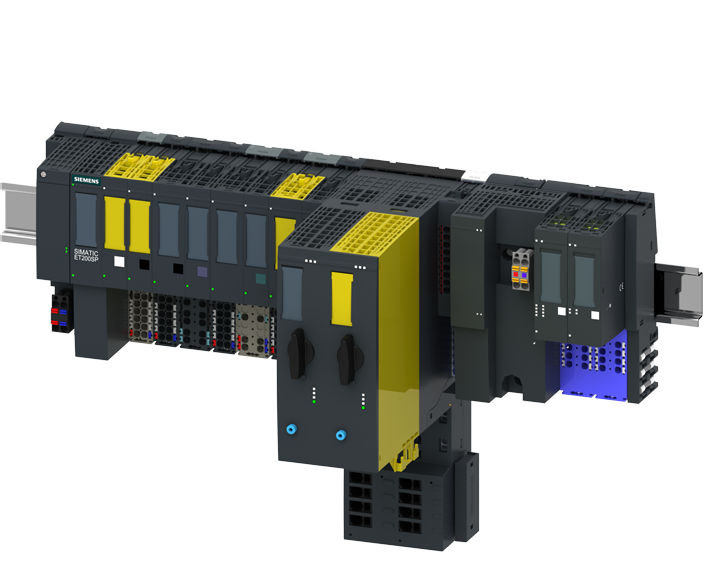

In [18]:
Show_Image("et200sp_system_manual_en-US_en-US_stripped", './data/et200sp_system_manual_en-US_en-US_stripped_images/p3-179.png')

## Bringing all of it together

### Using extra llm step to parse JSON
-> Not deterministic, therefore sometimes parsing does not work

Original Response: 
The steps for installing/mounting a CM DP communication module are:

1. Install the CM DP to the right of the CPU.
2. Swivel the CM DP towards the back until you hear the mounting rail release button click into place.
3. Slide the CM DP to the left until you hear it click into the CPU.

These steps can be found on page 62, parent section "Installing CM DP", and hierarchy section "7.5 Installing the CM DP communication module > Installing CM DP".
--------------------------------------------------------------------------------
Formated Response:
{
"response": "The steps for installing/mounting a CM DP communication module are:\n1. Install the CM DP to the right of the CPU.\n2. Swivel the CM DP towards the back until you hear the mounting rail release button click into place.\n3. Slide the CM DP to the left until you hear it click into the CPU.",
"section_hierarchy": "7.5 Installing the CM DP communication module > Installing CM DP",
"page_nrs": [62]
}
et200sp_system_m

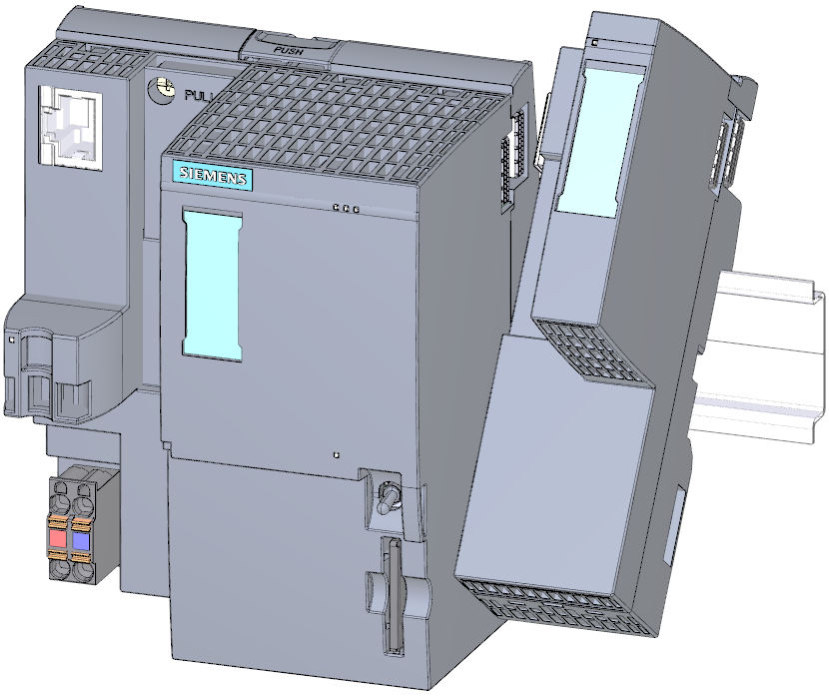

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Final Parsed JSON:
response: The steps for installing/mounting a CM DP communication module are:
1. Install the CM DP to the right of the CPU.
2. Swivel the CM DP towards the back until you hear the mounting rail release button click into place.
3. Slide the CM DP to the left until you hear it click into the CPU.
section_hierarchy: 7.5 Installing the CM DP communication module > Installing CM DP
page_nrs: [62]
image_file_paths: ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p62-579.png']


In [84]:
import json

json_query_engine = RetrieverQueryEngine.from_args(
    retriever=retriever, 
    response_synthesizer=response_synthesizer, 
    node_postprocessors=node_postprocessors, 
    response_mode=response_mode
)

query_engine.update_prompts({"response_synthesizer:text_qa_template": qa_template,
                                 "response_synthesizer:summary_template": summary_template,
                                "response_synthesizer:refine_template": refine_template})

response = query_engine.query("What are the steps for installing/mounting a CM DP communication module? Do not include any introductory sentences.")
print("Original Response: ")
print(response)
print("-"*80)



templateQA_JSON = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Given the text below create a single json in the following format. Do not use an introductory sentence. \
{{ \
  'response' // A string containing the complete text \
  'section_hierarchy' // A string conatining the section hierarchy where the answer can be found\
  'page_nrs' // A list of int with all the page number(s) in the metadata where the answer can be found \
}}<|eot_id|>
<|start_header_id|>user<|end_header_id|>

# Text: {query_str}
# Answer: <|eot_id|>
# <|start_header_id|>assistant<|end_header_id|>"""

json_query_engine.update_prompts({"response_synthesizer:text_qa_template": PromptTemplate(templateQA_JSON),
                                 "response_synthesizer:summary_template": PromptTemplate(templateQA_JSON),
                                "response_synthesizer:refine_template": PromptTemplate(templateQA_JSON)})

# response = query_engine.query("Give me the steps of mounting/installing a cpu/interface module? Do not include any introductory sentences.")
json_response = json_query_engine.query(response.response)

print("Formated Response:")
print(json_response.response)

# print("="*80)
parsed_dict = json.loads(json_response.response)

# # print(parsed_dict)
# print(parsed_dict["response"])
# print("-"*80)
# print(parsed_dict["section_hierarchy"])
# print("-"*80)
# print(parsed_dict["page_nrs"])


pdf_name = "et200sp_system_manual_en-US_en-US_stripped"

image_file_paths = []

for page_nr in parsed_dict["page_nrs"]:
  image_file_paths.extend(get_image_file_paths(pdf_name=pdf_name, page_idx=page_nr))
    

print(image_file_paths)


for file_path in image_file_paths:
  Show_Image(pdf_name=pdf_name, file_path=file_path)

parsed_dict["image_file_paths"] = image_file_paths


print("%"*100)
print("Final Parsed JSON:")
for key, value in parsed_dict.items():
    print(f"{key}: {value}")

In [19]:
import re

def extract_page_numbers(text):
    # Define the regex pattern to find different page number formats
    pattern = (
        r'page (\d+)|'                  # "page <int>"
        r'pages (\d+)-(\d+)|'           # "pages <int>-<int>"
        r'Page (\d+)|'                  # "Page <int>"
        r'Pages (\d+)-(\d+)|'           # "Pages <int>-<int>"
        r'page number: (\d+)|'          # "page number: <int>"
        r'Page number: (\d+)|'          # "Page number: <int>"
        r'Page Number: (\d+)|'          # "Page Number: <int>"
        r'Page Numbers: ([\d, ]+)|'     # "Page Numbers: <int>, <int>, ..."
        r'page numbers: ([\d, ]+)|'     # "page numbers: <int>, <int>, ..."
        r'page numbers are (\d+)'       # "page numbers are <int>"
    )
    
    # Find all matches in the text
    matches = re.findall(pattern, text, re.IGNORECASE)
    
    # Set to hold all page numbers (to avoid duplicates)
    page_numbers = set()
    
    # Process matches
    for match in matches:
        if match[0]:  # single page number, matched by "page <int>"
            page_numbers.add(int(match[0]))
        elif match[1] and match[2]:  # page range, matched by "pages <int>-<int>"
            start, end = int(match[1]), int(match[2])
            page_numbers.update(range(start, end + 1))
        elif match[3]:  # single page number, matched by "Page <int>"
            page_numbers.add(int(match[3]))
        elif match[4] and match[5]:  # page range, matched by "Pages <int>-<int>"
            start, end = int(match[4]), int(match[5])
            page_numbers.update(range(start, end + 1))
        elif match[6]:  # single page number, matched by "page number: <int>"
            page_numbers.add(int(match[6]))
        elif match[7]:  # single page number, matched by "Page number: <int>"
            page_numbers.add(int(match[7]))
        elif match[8]:  # single page number, matched by "Page Number: <int>"
            page_numbers.add(int(match[8]))
        elif match[9]:  # multiple page numbers, matched by "Page Numbers: <int>, <int>, ..."
            numbers = re.findall(r'\d+', match[9])  # Find all individual numbers in the string
            page_numbers.update(map(int, numbers))
        elif match[10]:  # multiple page numbers, matched by "page numbers: <int>, <int>, ..."
            numbers = re.findall(r'\d+', match[10])  # Find all individual numbers in the string
            page_numbers.update(map(int, numbers))
        elif match[11]:  # single page number, matched by "page numbers are <int>"
            page_numbers.add(int(match[11]))
    
    # Convert the set to a sorted list
    page_numbers = sorted(page_numbers)
    
    return page_numbers

In [36]:
import json

def QueryWithJSONResponse(query_str, print_context_nodes=False):
    # query
    new_res = query_engine.query(query_str)


    text = new_res.response
    page_numbers = extract_page_numbers(new_res.response)

    # Initialize parsed_dict
    parsed_dict = {}
    parsed_dict["text"] = text
    parsed_dict["page_numbers"] = page_numbers

    print("Response:")
    print(new_res)

    # parsed_dict = json.loads(response.response)

    pdf_name = "et200sp_system_manual_en-US_en-US_stripped"
    image_file_paths = []

    for page_nr in parsed_dict["page_numbers"]:
        image_file_paths.extend(get_image_file_paths(pdf_name=pdf_name, page_idx=page_nr))
        
    parsed_dict["image_file_paths"] = image_file_paths

    # print(image_file_paths)


    for file_path in image_file_paths:
        Show_Image(pdf_name=pdf_name, file_path=file_path)

    print("-"*80)
    print("Parsed DICT:")
    for key, value in parsed_dict.items():
         print(f"{key}: {value}")

    # convert dictionary to JSON object
    json_object = json.dumps(parsed_dict)

    print("-"*80)
    print("Final JSON Object:")
    print(json_object)

    if print_context_nodes:
        visualize_retrieved_nodes(new_res.source_nodes)

    return json_object

In [37]:
QueryWithJSONResponse("What are the steps for installing/mounting a CM DP communication module? Also provide the corresponding page numbers and section hierarchy.")

AttributeError: 'StreamingResponse' object has no attribute 'response'

Response:
According to the technical manual, the function of a PotDis-BaseUnit potential distributor module is to distribute a variety of potentials (P1, P2) and allow you to implement a multi-cable connection without external terminals with 16-channel digital modules. This module has two parts: a PotDis-BaseUnit and an optional PotDis-TerminalBlock that can be plugged onto it.

Parent Section Hierarchy: SIMATIC > ET 200SP > System overview > 5.4 Components > 5.4 Components

Page Number: 16
et200sp_system_manual_en-US_en-US_stripped_16
PDF name: et200sp_system_manual_en-US_en-US_stripped
Image file name: ./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-922.png


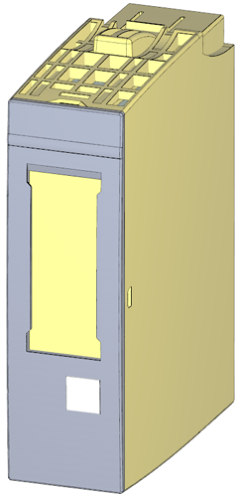

PDF name: et200sp_system_manual_en-US_en-US_stripped
Image file name: ./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-922.png


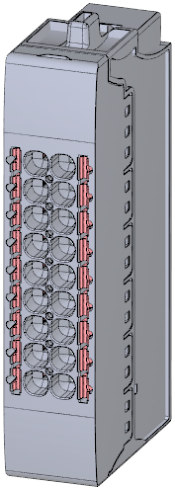

PDF name: et200sp_system_manual_en-US_en-US_stripped
Image file name: ./data/et200sp_system_manual_en-US_en-US_stripped_images/p118-922.png


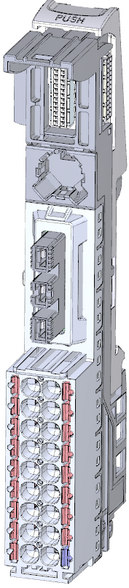

--------------------------------------------------------------------------------
Parsed DICT:
text: According to the technical manual, the function of a PotDis-BaseUnit potential distributor module is to distribute a variety of potentials (P1, P2) and allow you to implement a multi-cable connection without external terminals with 16-channel digital modules. This module has two parts: a PotDis-BaseUnit and an optional PotDis-TerminalBlock that can be plugged onto it.

Parent Section Hierarchy: SIMATIC > ET 200SP > System overview > 5.4 Components > 5.4 Components

Page Number: 16
page_numbers: [16]
image_file_paths: ['./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-298.png', './data/et200sp_system_manual_en-US_en-US_stripped_images/p16-297.png', './data/et200sp_system_manual_en-US_en-US_stripped_images/p16-296.png']
--------------------------------------------------------------------------------
Final JSON Object:
{"text": "According to the technical manual, the function of

'{"text": "According to the technical manual, the function of a PotDis-BaseUnit potential distributor module is to distribute a variety of potentials (P1, P2) and allow you to implement a multi-cable connection without external terminals with 16-channel digital modules. This module has two parts: a PotDis-BaseUnit and an optional PotDis-TerminalBlock that can be plugged onto it.\\n\\nParent Section Hierarchy: SIMATIC > ET 200SP > System overview > 5.4 Components > 5.4 Components\\n\\nPage Number: 16", "page_numbers": [16], "image_file_paths": ["./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-298.png", "./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-297.png", "./data/et200sp_system_manual_en-US_en-US_stripped_images/p16-296.png"]}'

In [67]:
QueryWithJSONResponse("Tell me the function of a PotDis-BaseUnit potential distributor module. Also provide the corresponding page numbers and section hierarchy.", 
                      print_context_nodes=False)

### TODO: Test llamaparse for PDF parsing
https://docs.llamaindex.ai/en/stable/module_guides/loading/connector/llama_parse/

--> DONE: Parsing and indexing is superior to llmsherpa out of the box but requires payed API key

### TODO: Benchmarking


- Retrieval Evaluation: This assesses the accuracy and relevance of the information retrieved by the system.
- Response Evaluation: This measures the quality and appropriateness of the responses generated by the system based on the retrieved information.


In [33]:
def add_qa_to_list(lst, question, answer):
    lst.append({question: answer})
    return lst

qa_list = []
add_qa_to_list(qa_list, "What is the first step in mounting the CPU/interface module?", "Install the CPU/interface module on the mounting rail.")
add_qa_to_list(qa_list, "What tools are needed for the installation of ET 200SP R1?", "3 to 3.5 mm screwdriver (only for mounting and removing the BusAdapter)")
add_qa_to_list(qa_list, "What are the requirements for installing a ET 200SP R1??", "The SIMATIC system rail is installed.")
add_qa_to_list(qa_list, "Which type of mounting rails can I use for motor starters?", "– 35x15 mm DIN rail in accordance with DIN EN 60715\n– 35x7.5 mm DIN rail in accordance with DIN EN 60715\n– SIMATIC S7 mounting rail")


[{'What is the first step in mounting the CPU/interface module?': 'Install the CPU/interface module on the mounting rail.'},
 {'What tools are needed for the installation of ET 200SP R1?': '3 to 3.5 mm screwdriver (only for mounting and removing the BusAdapter)'},
 {'What are the requirements for installing a ET 200SP R1??': 'The SIMATIC system rail is installed.'},
 {'Which type of mounting rails can I use for motor starters?': '– 35x15 mm DIN rail in accordance with DIN EN 60715\n– 35x7.5 mm DIN rail in accordance with DIN EN 60715\n– SIMATIC S7 mounting rail'}]

In [39]:
def get_context_string(response):
    string = ""
    for node in response.source_nodes:
        string += f"Context Metadata:\n"
        string += f"{node.node.metadata}\n"
        string += f"Context Text:\n"
        string += f"{node.text}\n"
        string += "\n\n"
    return string

In [53]:
templateEvalContextRelevance = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Your task is to evaluate if the provided context information is sufficient to answer a question correctly. \
You are provided with the context and the expected response. \n
You have two options to answer. Either YES/ NO. \n
Answer - YES, if all the information in the expected response are included in the context otherwise NO.<|eot_id|>
<|start_header_id|>user<|end_header_id|>

Context: \n {context_str}\n
Expected Response: \n {expected_response}\n
Answer: <|eot_id|>
<|start_header_id|>assistant<|end_header_id|>"""

eval_template = PromptTemplate(templateEvalContextRelevance)

In [58]:
eval_index = VectorStoreIndex([])
eval_query_engine = eval_index.as_chat_engine()

def execute_evaluation(qa_entry):
    query = list(qa_entry.keys())[0]
    expected_repsonse = list(qa_entry.values())[0]

    # Execute query with question
    response = query_engine.query(query)

    # Get retrieved context
    context = get_context_string(response)
    expected_repsonse = expected_repsonse

    # Print everything for debugging
    print("--------------------------Query: --------------------------")
    print(query)
    print("--------------------------Response: --------------------------")
    print(response)
    print("--------------------------Context: --------------------------")
    print(context)
    print("--------------------------Expected Response: --------------------------")
    print(expected_repsonse)

    # Generate evaluation prompt
    eval_prompt = eval_template.format(context_str=context, expected_response=expected_repsonse)

    # Evaluate the context relevance
    eval_response = eval_query_engine.query(eval_prompt)

    print("--------------------------Evaluation : --------------------------")
    print(eval_response)

    return eval_response

In [59]:
execute_evaluation(qa_list[1])

--------------------------Query: --------------------------
What tools are needed for the installation of ET 200SP R1?
--------------------------Response: --------------------------
The typical tools and equipment needed for installing Siemens ET 200SP R1 compact controllers include screwdrivers, Allen wrenches, wire strippers, crimping tools, and a multimeter. Additionally, a programming device such as a laptop with the corresponding software may be required for configuration purposes.
--------------------------Context: --------------------------

--------------------------Expected Response: --------------------------
3 to 3.5 mm screwdriver (only for mounting and removing the BusAdapter)
--------------------------Evaluation : --------------------------
You would need a 3 to 3.5 mm screwdriver for mounting and removing the BusAdapter.


Response(response='You would need a 3 to 3.5 mm screwdriver for mounting and removing the BusAdapter.', source_nodes=[], metadata=None)